In [1]:
import cimpy
from cimpy import CIM2DPsim
from cimpy.CIM2DPsim import Domain
from cimpy.cgmes_v2_4_15.Base import short_profile_name
import os
from pathlib import Path

import sys
sys.path.insert(0,'/home/mmo-cya/dpsim/build')
import dpsimpy



example_dir = Path(os.path.join('../cimpy/examples/sampledata/IEEE14')).resolve()

test_files = []
for file in example_dir.glob('*.xml'):
    test_files.append(str(file.absolute()))

imported_result = cimpy.cim_import(test_files, 'cgmes_v2_4_15')



CIM object Diagram created : 1 times
CIM object DiagramObjectPoint created : 168 times
CIM object DiagramObject created : 77 times
CIM object SvPowerFlow created : 16 times
CIM object SvVoltage created : 14 times
CIM object SvTapStep created : 5 times
CIM object TopologicalIsland created : 1 times
CIM object TopologicalNode created : 14 times
CIM object VoltageLimit created : 14 times
CIM object Terminal created : 58 times
CIM object VoltageLevel created : 14 times
CIM object OperationalLimitSet created : 56 times
CIM object PowerTransformer created : 5 times
CIM object ConformLoad created : 11 times
CIM object SubGeographicalRegion created : 1 times
CIM object RegulatingControl created : 5 times
CIM object BaseVoltage created : 4 times
CIM object PowerTransformerEnd created : 10 times
CIM object CurrentLimit created : 42 times
CIM object LoadArea created : 1 times
CIM object ConformLoadGroup created : 1 times
CIM object OperationalLimitType created : 2 times
CIM object RatioTapChanger

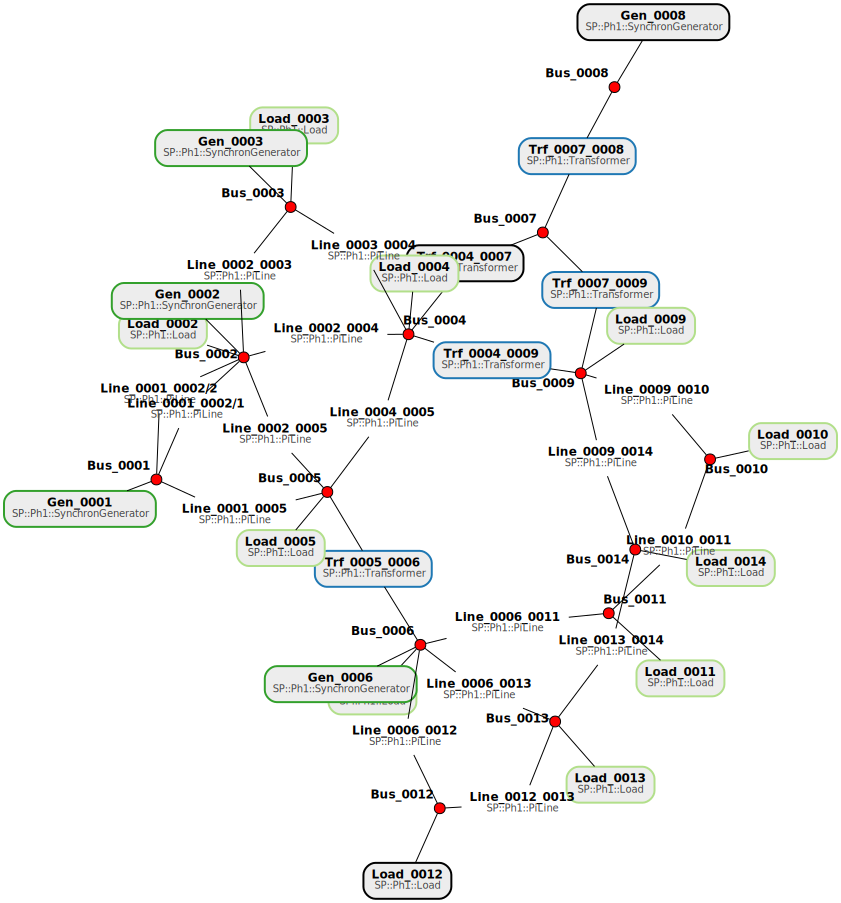

In [2]:
system_SP = CIM2DPsim.CIM2DPsim(imported_result, Domain.PF)
system_SP

In [3]:
name = "IEEE14_ReaderTest1"
dpsimpy.Logger.set_log_dir("logs/" + name)

    ### Simulation
sim = dpsimpy.Simulation(name, dpsimpy.LogLevel.debug)
sim.set_system(system_SP)
sim.set_domain(dpsimpy.Domain.SP)
sim.set_solver(dpsimpy.Solver.NRP)
sim.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim.set_time_step(0.1)
sim.set_final_time(0.5)
sim.run()

[10:59:03.212976 IEEE14_ReaderTest1 info] Initialize simulation: IEEE14_ReaderTest1
[10:59:03.229511 IEEE14_ReaderTest1_PF_Solver warning] Unable to get base voltage at Bus_0010
[10:59:03.229524 IEEE14_ReaderTest1_PF_Solver warning] Unable to get base voltage at Bus_0014
[10:59:03.229532 IEEE14_ReaderTest1_PF_Solver warning] Unable to get base voltage at Bus_0011
[10:59:03.229538 IEEE14_ReaderTest1_PF_Solver warning] Unable to get base voltage at Bus_0002
[10:59:03.229573 IEEE14_ReaderTest1_PF_Solver warning] Unable to get base voltage at Bus_0012
[10:59:03.229580 IEEE14_ReaderTest1_PF_Solver warning] Unable to get base voltage at Bus_0003
[10:59:03.229587 IEEE14_ReaderTest1_PF_Solver warning] Unable to get base voltage at Bus_0013
[10:59:03.230235 IEEE14_ReaderTest1 info] Scheduling tasks.
[10:59:03.230406 IEEE14_ReaderTest1 info] Scheduling done.
[10:59:03.230409 IEEE14_ReaderTest1 info] Opening interfaces.
[10:59:03.230411 IEEE14_ReaderTest1 info] Start synchronization with remotes 

In [4]:
system_SP.nodes[0].name
for i in system_SP.nodes:
    if 'Bus_0006' == i.name:
        print(i.initial_single_voltage())

0j


CIMContentHandler: Note: 0 out of 830 tasks remain unresolved!


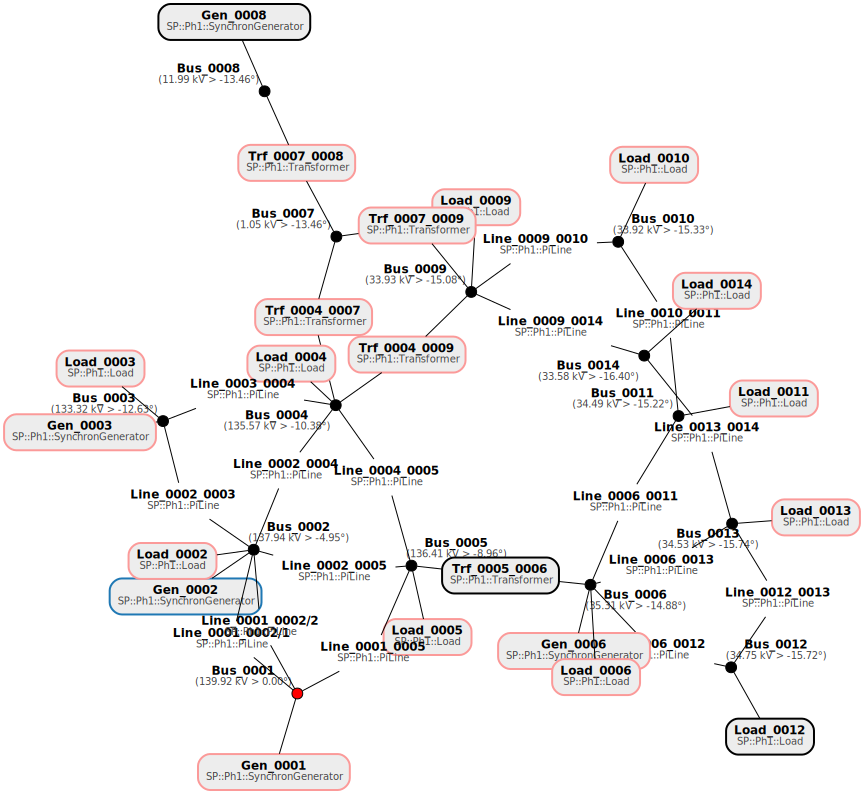

In [5]:

system= dpsimpy.SystemTopology(60)


reader = dpsimpy.CIMReader("system")
system = reader.loadCIM(60, test_files, dpsimpy.Domain.SP, dpsimpy.PhaseType.Single, dpsimpy.GeneratorType.PVNode)
system

In [6]:
print(len(system.nodes))
len(system_SP.nodes)

14


14